In [1]:
import numpy as np # scientific computing
import pandas as pd # data loading and processing
import os # os operations
import matplotlib.pyplot as plt # for generating figures
import math
import matplotlib.dates as mdates
import seaborn as sns # for generating visualizations, better support with pandas than matplotlib
from scipy import stats

In [22]:
def get_gene_names(filename,col=None):
    file = pd.read_csv(filename, index_col=None, header= 0).T
    names = file[col].dropna().tolist()
    return names

def construct_filename(c, db):
    if db =="xena":
        n1 = "./data/" + "TCGA." + c + ".sampleMap_HiSeqV2"
        n2 = "./data/" + "TCGA." + c + ".sampleMap_"+ c +"_clinicalMatrix"
    elif db == "cbio":
        n1 = "./data/" + c+"_data_mrna_seq_v2_rsem.txt"
        n2 = "./data/" + c + "_data_clinical_sample.txt"
    else:
        print("db must be either xena or cbio")
    return n1,n2

def construct_hccdb_filename(n):
    n1 = "./data/HCCDB/HCCDB" + n + "_mRNA_level3.txt"
    n2 = "./data/HCCDB/HCCDB" + n  + ".sample.txt"
    return n1,n2

def process_data(df, targets, y_var_names, pheno_filtered=None):

    # subset to get relevant genes
    df_filtered = df.loc[targets]
    # print(df_filtered)
    print(df_filtered.isnull().values.any())

    # check for nan values
    na_filter = df_filtered.isnull().any()
    na_ls = na_filter[na_filter == True].index.to_list()
    print(na_ls)
    
    # impute nan values
    mean_ls = df_filtered.mean()
    for na_col in na_ls:
        df_filtered[na_col] = df_filtered[na_col].fillna(mean_ls[na_col])
    
    print(df_filtered.isnull().values.any())
    df_filtered = df_filtered.T # patients x genes

    # scale numerical data
    df_filtered = np.log10(df_filtered+1)
    print("pass")

    # for each sequenced gene were rescaled to set the median equal to 1
    df_filtered=((df_filtered-df_filtered.median())/df_filtered.std())+1

    # add sample type labels
    if pheno_filtered is not None:
        data = pd.concat([df_filtered, pheno_filtered], axis = 1, join='inner')
    
    # take only nrf2 target genes
    y_var_gene_set = data[y_var_names]
    data.drop(y_var_names, inplace = True, axis = 1)
    y_var_gene_set["composite_score"] = y_var_gene_set.mean(axis = 1)
    data = pd.concat([data, y_var_gene_set], axis = 1) # patients x genes 
    
    return data

def analyse(data, fig, name, ax, fn, x_target = "RRM2B", y_target = "composite_score"):
    #find line of best fit
    y, x = data[y_target].to_numpy(), data[x_target].to_numpy()
    a, b = np.polyfit(x, y, 1)

    iqr = data[x_target].T.describe()

    # bin the patients into quartiles based on G6PD expression
    data["RRM2B levels"] = pd.cut(data["RRM2B"],
                    bins=[ iqr["min"], iqr["25%"], iqr["75%"], iqr["max"]],
                    labels=["Bottom 25%", "-", "Top 25%"])

    # get r sq val
    r = np.corrcoef(x, y)[0, 1]

    #find p-value
    n = data.shape[0]
    t = (r-math.sqrt(n-2))/math.sqrt(1-(r**2))
    p = stats.t.sf(abs(t), df=n)*2

    # plot the data
    # scatter plot for RRM2B against NRF2 activity
    sns.set_style("whitegrid")
    sns.set()
    sns.scatterplot(data=data, x=x_target, y=y_target, ax= ax)
    ax.plot(x, a*x+b, color="black")
    ax.set_ylabel("NRF2 activity (based on 53 genes)",fontsize = 18)
    ax.set_xlabel("RRM2B expression" + " \n (r = " + str(round(r, 4)) + "," + " p = " + str(round(p, 4)) +")",rotation=10,fontsize = 15)
    ax.set_title(name, fontsize = 20)
    ax.tick_params(axis='both', which='major', labelsize=15)
    plt.show()

    # save the figure 
    fig.savefig(fn)

def get_targets_present(data, targets):
    idx = data.index.to_list()
    # print(idx)
    # print(targets)
    targets_present = list(set(idx).intersection(set(targets)))
    # print(targets_present)
    return targets_present

def get_xena_data(n1):
    df = pd.read_csv(n1, index_col = 0, sep = "\t") # gene x patient
    return df

def get_cbio_data(n1):
    df = pd.read_csv(n1, index_col = 0, sep = "\t").drop(["Entrez_Gene_Id"], axis=1) # gene x patient
    return df

def get_hccdb_data(n1):
    df = pd.read_csv(n1, index_col = 1, sep = "\t").drop(["Entrez_ID"], axis=1) # gene x patient
    return df

def get_xena_pheno(n2):
    pheno = pd.read_csv(n2, index_col=0, sep = "\t")
    pheno = pheno[["sample_type"]]
    pheno_filtered = pheno.dropna()
    return pheno_filtered

def get_cbio_pheno(n2):
    pheno = pd.read_csv(n2, index_col=1,header = 4, sep = "\t")
    pheno = pheno[["SAMPLE_TYPE"]]
    pheno_filtered = pheno.dropna()
    return pheno_filtered

def get_hccdb_pheno(n2):
    pheno = pd.read_csv(n2, index_col=0, sep = "\t").T
    pheno = pheno[["TYPE"]]
    pheno_filtered = pheno.dropna()
    return pheno_filtered



In [3]:
# script to sort all data into low vs high RRM2B status

hccdb_names = ["1", "3", "4",  "8", "9", "11", "12", "13", "14", "16", "17", "18"]
hccdb = pd.DataFrame()

for i in range(len(hccdb_names)):
    print(i)
    n1, n2 = construct_hccdb_filename(hccdb_names[i])
    hccdb_temp = get_hccdb_data(n1)
    hccdb_temp = hccdb_temp.loc[~hccdb_temp.index.duplicated(),:].copy()
    hccdb_temp.loc["ptype",:] = "HCCDB-" + hccdb_names[i]
    hccdb = pd.concat([hccdb, hccdb_temp], axis = 1) # patients x genes
    


0
1
2
3
4
5
6
7


/var/folders/mp/lfr86vf57gzgqs4tr6qd5bs80000gn/T/ipykernel_41190/493598103.py:113: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(n1, index_col = 1, sep = "\t").drop(["Entrez_ID"], axis=1) # gene x patient


8
9
10
11


In [12]:
hccdb

,HCCDB-1.S1,HCCDB-1.S2,HCCDB-1.S3,HCCDB-1.S4,HCCDB-1.S5,HCCDB-1.S6,HCCDB-1.S7,HCCDB-1.S8,HCCDB-1.S9,HCCDB-1.S10,...,HCCDB-18.S380,HCCDB-18.S381,HCCDB-18.S382,HCCDB-18.S383,HCCDB-18.S384,HCCDB-18.S385,HCCDB-18.S386,HCCDB-18.S387,HCCDB-18.S388,HCCDB-18.S389
Symbol,,,,,,,,,,,,,,,,,,,,,
PDXDC1,8.1804,7.9842,8.8103,7.6255,6.378,9.1426,8.5225,6.1033,6.2784,8.8593,...,4.78,4.94,4.73,5.59,4.81,4.87,4.68,4.78,3.88,5.14
DGKK,3.12565,3.05915,2.7929,3.04215,3.0406,2.9191,3.1426,2.7012,2.9807,3.04185,...,0.15,0.0,0.0,0.0,0.06,0.17,0.0,0.0,0.35,0.0
ZNF417,5.7213,5.91835,5.6876,5.9751,6.3881,5.96585,5.5097,6.0359,5.5095,5.44995,...,0.63,1.28,1.0,1.92,1.04,1.75,1.47,1.31,0.44,0.98
PTCD3,8.8248,8.19005,8.37045,8.4994,8.0901,8.12535,8.3818,9.12295,8.16705,9.2308,...,2.86,3.08,3.07,4.13,4.1,3.08,4.16,3.3,3.49,3.09
SPTBN1,9.8427,9.9694,9.7228,9.6847,10.6949,9.9889,10.2911,8.9471,10.5455,9.9844,...,5.11,4.63,5.27,5.36,6.43,4.85,4.52,6.41,3.78,4.84
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
MIR4752,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
MIR3148,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
MIR526A1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.13,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [4]:
tcga = pd.read_csv("./data/EB++AdjustPANCAN_IlluminaHiSeq_RNASeqV2.geneExp (1).xena", index_col = 0, sep = "\t") # gene x patient
pheno = pd.read_csv("./data/TCGA_phenotype_denseDataOnlyDownload (1).tsv", index_col = 0, sep = "\t") # patient x phenotype

In [13]:
tcga.head()

,TCGA-OR-A5J1-01,TCGA-OR-A5J2-01,TCGA-OR-A5J3-01,TCGA-OR-A5J5-01,TCGA-OR-A5J6-01,TCGA-OR-A5J7-01,TCGA-OR-A5J8-01,TCGA-OR-A5J9-01,TCGA-OR-A5JA-01,TCGA-OR-A5JB-01,...,TCGA-CG-4449-01,TCGA-CG-4462-01,TCGA-CG-4465-01,TCGA-CG-4466-01,TCGA-CG-4469-01,TCGA-CG-4472-01,TCGA-CG-4474-01,TCGA-CG-4475-01,TCGA-CG-4476-01,TCGA-CG-4477-01
sample,,,,,,,,,,,,,,,,,,,,,
100130426,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
100133144,2.09,1.88,1.45,0.00,0.00,1.12,1.29,0.00,2.45,3.02,...,2.42,2.74,2.64,3.99,4.40,3.00,4.27,3.71,4.29,4.24
100134869,2.30,3.32,2.92,1.35,2.45,2.82,1.72,1.24,2.60,0.00,...,1.87,2.12,1.78,2.60,3.66,3.87,3.07,3.65,3.64,3.99
10357,7.23,6.36,6.45,5.78,6.09,6.71,6.58,6.31,6.13,7.29,...,9.31,8.20,9.43,9.14,10.02,9.32,9.54,8.99,9.48,9.46
10431,10.99,10.35,10.04,11.20,10.30,10.87,9.96,10.78,10.25,10.97,...,10.23,9.33,10.21,9.38,9.34,10.34,10.17,10.43,9.93,10.76


In [5]:
data = tcga.T
data.head()

sample,100130426,100133144,100134869,10357,10431,136542,155060,26823,280660,317712,...,ZWILCH,ZWINT,ZXDA,ZXDB,ZXDC,ZYG11A,ZYG11B,ZYX,ZZEF1,ZZZ3
TCGA-OR-A5J1-01,0.0,2.09,2.30,7.23,10.99,0.0,8.10,1.29,0.0,0.0,...,7.53,7.21,4.44,8.46,10.04,0.57,9.34,10.85,10.18,9.22
TCGA-OR-A5J2-01,0.0,1.88,3.32,6.36,10.35,0.0,7.65,0.00,0.0,0.0,...,8.05,8.78,5.86,8.13,11.54,5.02,10.19,11.58,10.89,9.65
TCGA-OR-A5J3-01,0.0,1.45,2.92,6.45,10.04,0.0,8.45,0.67,0.0,0.0,...,6.52,7.58,5.35,8.96,9.84,0.67,9.66,11.38,10.53,8.78
TCGA-OR-A5J5-01,0.0,0.00,1.35,5.78,11.20,0.0,8.78,0.83,0.0,0.0,...,8.03,9.72,4.23,7.69,9.80,3.66,9.12,11.21,10.16,9.01
TCGA-OR-A5J6-01,0.0,0.00,2.45,6.09,10.30,0.0,7.23,0.00,0.0,0.0,...,6.03,6.00,3.79,6.89,9.81,3.14,9.64,9.47,9.64,8.90


In [6]:
pheno.head()

,sample_type_id,sample_type,_primary_disease
sample,,,
TCGA-D3-A1QA-07,7.0,Additional Metastatic,skin cutaneous melanoma
TCGA-DE-A4MD-06,6.0,Metastatic,thyroid carcinoma
TCGA-J8-A3O2-06,6.0,Metastatic,thyroid carcinoma
TCGA-J8-A3YH-06,6.0,Metastatic,thyroid carcinoma
TCGA-EM-A2P1-06,6.0,Metastatic,thyroid carcinoma


In [7]:
data = pd.concat([data, pheno], axis = 1, join = "inner") # patients x genes

In [8]:
print(data.shape)
print(tcga.T.shape)

(11060, 20534)
(11069, 20531)


In [9]:
ls = data["_primary_disease"].unique().tolist()

conditions = [
    data['_primary_disease'] == 'adrenocortical cancer',
    data['_primary_disease'] == 'bladder urothelial carcinoma',
    data['_primary_disease'] == 'breast invasive carcinoma',
    data['_primary_disease'] == 'cervical & endocervical cancer',
    data['_primary_disease'] == 'cholangiocarcinoma', 
    data['_primary_disease'] == 'colon adenocarcinoma',
    data['_primary_disease'] == 'diffuse large B-cell lymphoma',
    data['_primary_disease'] == 'esophageal carcinoma',
    data['_primary_disease'] == 'glioblastoma multiforme',
    data['_primary_disease'] == 'head & neck squamous cell carcinoma',
    data['_primary_disease'] == 'kidney chromophobe',
    data['_primary_disease'] == 'kidney clear cell carcinoma',
    data['_primary_disease'] == 'kidney papillary cell carcinoma',
    data['_primary_disease'] == 'acute myeloid leukemia',
    data['_primary_disease'] == 'brain lower grade glioma',
    data['_primary_disease'] == 'liver hepatocellular carcinoma',
    data['_primary_disease'] == 'lung adenocarcinoma',
    data['_primary_disease'] == 'lung squamous cell carcinoma',
    data['_primary_disease'] == 'mesothelioma',
    data['_primary_disease'] == 'ovarian serous cystadenocarcinoma',
    data['_primary_disease'] == 'pancreatic adenocarcinoma',
    data['_primary_disease'] == 'pheochromocytoma & paraganglioma',
    data['_primary_disease'] == 'prostate adenocarcinoma',
    data['_primary_disease'] == 'rectum adenocarcinoma',
    data['_primary_disease'] == 'sarcoma',
    data['_primary_disease'] == 'skin cutaneous melanoma',
    data['_primary_disease'] == 'stomach adenocarcinoma',
    data['_primary_disease'] == 'testicular germ cell tumor',
    data['_primary_disease'] == 'thyroid carcinoma',
    data['_primary_disease'] == 'thymoma',
    data['_primary_disease'] == 'uterine corpus endometrioid carcinoma',
    data['_primary_disease'] == 'uterine carcinosarcoma',
    data['_primary_disease'] == 'uveal melanoma'    
]

choices = ["ACC",
           "BLCA",
           "BRCA",
           "CESC",
           "CHOL",
           "COAD",
           "DBLC",
           "ESCA",
           "GBM",
           "HNSC",
           "KICH",
           "KIRC",
           "KIRP",
           "LAML",
           "LGG",
           "LIHC",
           "LUAD",
           "LUSC",
           "MESO",
           "OV",
           "PAAD",
           "PCPG",
           "PRAD",
           "READ",
           "SARC",
           "SKCM",
           "STAD",
           "TGCT",
           "THCA",
           "THYM",
           "UCEC",
           "UCS",
           "UVM"
           ]

data["ptype"] = np.select(conditions, choices, default = "null")
data.head()

,100130426,100133144,100134869,10357,10431,136542,155060,26823,280660,317712,...,ZXDC,ZYG11A,ZYG11B,ZYX,ZZEF1,ZZZ3,sample_type_id,sample_type,_primary_disease,ptype
TCGA-OR-A5J1-01,0.0,2.09,2.30,7.23,10.99,0.0,8.10,1.29,0.0,0.0,...,10.04,0.57,9.34,10.85,10.18,9.22,1.0,Primary Tumor,adrenocortical cancer,ACC
TCGA-OR-A5J2-01,0.0,1.88,3.32,6.36,10.35,0.0,7.65,0.00,0.0,0.0,...,11.54,5.02,10.19,11.58,10.89,9.65,1.0,Primary Tumor,adrenocortical cancer,ACC
TCGA-OR-A5J3-01,0.0,1.45,2.92,6.45,10.04,0.0,8.45,0.67,0.0,0.0,...,9.84,0.67,9.66,11.38,10.53,8.78,1.0,Primary Tumor,adrenocortical cancer,ACC
TCGA-OR-A5J5-01,0.0,0.00,1.35,5.78,11.20,0.0,8.78,0.83,0.0,0.0,...,9.80,3.66,9.12,11.21,10.16,9.01,1.0,Primary Tumor,adrenocortical cancer,ACC
TCGA-OR-A5J6-01,0.0,0.00,2.45,6.09,10.30,0.0,7.23,0.00,0.0,0.0,...,9.81,3.14,9.64,9.47,9.64,8.90,1.0,Primary Tumor,adrenocortical cancer,ACC


In [10]:
print(sum(tcga.isnull().sum() >0))
print(sum(data.isnull().sum() >0))
print(tcga.isnull().sum() > 0)

tcga.loc[:, tcga.isnull().sum() > 0]
len(data["ptype"].unique())

1751
4196
TCGA-OR-A5J1-01    False
TCGA-OR-A5J2-01    False
TCGA-OR-A5J3-01    False
TCGA-OR-A5J5-01    False
TCGA-OR-A5J6-01    False
                   ...  
TCGA-CG-4472-01     True
TCGA-CG-4474-01     True
TCGA-CG-4475-01     True
TCGA-CG-4476-01     True
TCGA-CG-4477-01     True
Length: 11069, dtype: bool


33

ACC
False
[]
False


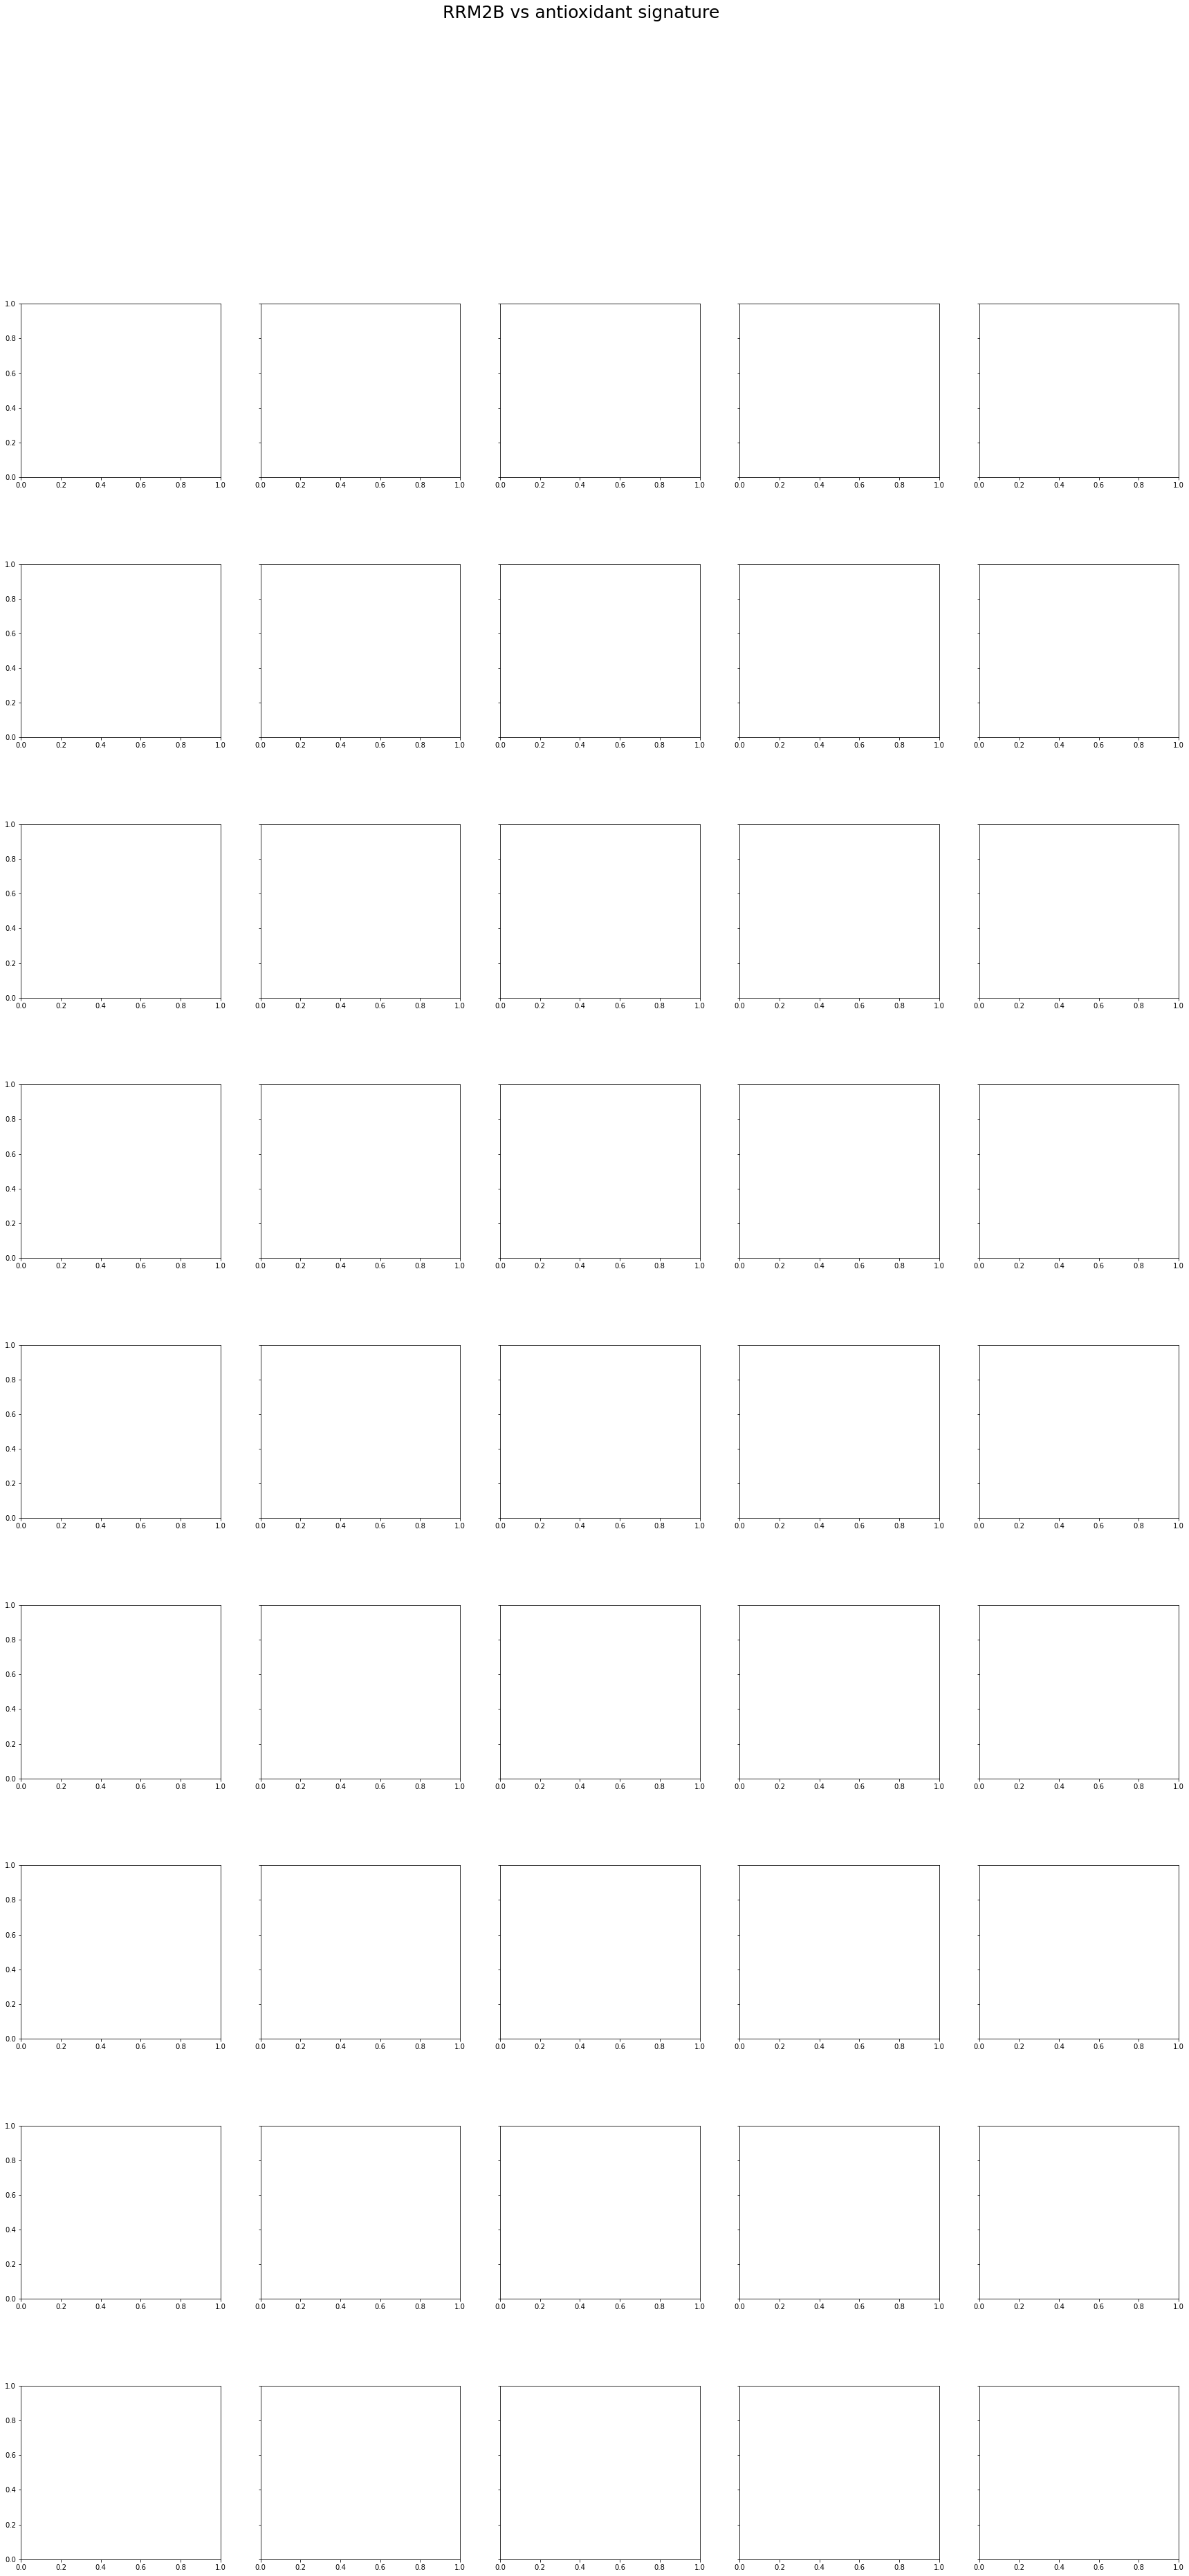

In [23]:
# get names of ox_stress target genes

gene_set = pd.read_csv("./data/oxstress genes.csv", index_col=None, header= 0)
gene_set = gene_set['Review v3'].dropna().tolist()

targets = list(set(["G6PD", "RRM2B"] +  gene_set))

rval1 =[]
rval2 = []
databases = ['ACC', 'BLCA', 'DBLC', 'UCEC', 'SKCM', 'HNSC', 'PRAD', 'KIRP',
       'PAAD', 'SARC', 'CESC', 'COAD', 'LUSC', 'READ', 'KIRC', 'LIHC',
       'BRCA', 'OV', 'UCS', 'GBM', 'KICH', 'THCA', 'LGG', 'LUAD', 'MESO',
       'PCPG', 'TGCT', 'UVM', 'THYM', 'CHOL', 'ESCA', 'STAD', 'LAML','PANCAN',
       'HCCDB-1', 'HCCDB-3', 'HCCDB-4',  'HCCDB-8', 'HCCDB-9', 'HCCDB-11', 
         'HCCDB-12', 'HCCDB-13', 'HCCDB-14', 'HCCDB-16', 'HCCDB-17', 'HCCDB-18'] # , , 'PANCAN'

# define subplot grid
fig, axs = plt.subplots(9, 5, figsize=(30, 60), sharey=True)
plt.subplots_adjust(hspace=0.5)
fig.suptitle('RRM2B vs antioxidant signature',fontsize = 25)

for db, ax in zip(databases, axs.ravel()):
    print(db)
    if db.startswith("HCCDB"):
        df = hccdb[hccdb["ptype"] == db]
    elif db == "PANCAN":
        df = data
        df = df.T
    else:
        df = data[data["ptype"] == db]
        df = df.T
        data_new = process_data(df, targets, gene_set, pheno_filtered=None)
    # print("pass")
    analyse(data_new, fig, db, ax, 'RRM2B vs antioxidant screen.png', x_target = 'RRM2B', y_target = 'composite_score')
    print("done")


In [ ]:
# get names of ox_stress target genes

gene_set = pd.read_csv("./data/oxstress genes.csv", index_col=None, header= 0)
gene_set = gene_set['NRF2 v3'].dropna().tolist()

targets = list(set(["G6PD", "RRM2B"] +  gene_set))

rval1 =[]
rval2 = []
cancer = ['ACC', 'BLCA', 'DBLC', 'UCEC', 'SKCM', 'HNSC', 'PRAD', 'KIRP',
       'PAAD', 'SARC', 'CESC', 'COAD', 'LUSC', 'READ', 'KIRC', 'LIHC',
       'BRCA', 'OV', 'UCS', 'GBM', 'KICH', 'THCA', 'LGG', 'LUAD', 'MESO',
       'PCPG', 'TGCT', 'UVM', 'THYM', 'CHOL', 'ESCA', 'STAD', 'LAML','PANCAN'] # , , "PANCAN"

fig, axs = plt.subplots(1, len(cancer), figsize=(30, 10), sharey=True)
fig.suptitle('RRM2B vs NRF2 activity',fontsize = 25)

for c in cancer:
    n1, n2 = construct_filename(c, "cbio")
    df = get_cbio_data(n1)
    pheno_filtered = get_cbio_pheno(n2)
    data = process_data(df, targets, gene_set, pheno_filtered)
    analyse(data, fig, axs, cancer, c, "RRM2B vs NRF2 final.png", x_target = "RRM2B", y_target = "composite_score")
